## MovieLens Session Based Recommendation


In [1]:
import pandas as pd 
import numpy as np 

import datetime as dt
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras 
from keras.layers import Input, Dense, Dropout, GRU
from keras.losses import categorical_crossentropy
from keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical 
from tqdm import tqdm # bar 형식으로 진행사항 확인 


In [2]:
file_path = Path(os.getcwd() + '/data')
movie_path = file_path / 'movies.dat'
rating_path = file_path / 'ratings.dat'
user_path = file_path /'users.dat'
readme_path = file_path /'README.txt'

In [3]:
readme = open(readme_path, 'r')

while True:
    line = readme.readline()
    if not line: break
    print(line)

readme.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

### data info 정리 
Ratings 
- UserID::MovieID::Rating::Timestamp  
<br>

Users
- UserID::Gender::Age::Occupation::Zip-code  
- age 1 means Under 18   

<br>

Movies
- MovieID::Title::Genres

지금 하고자 하는 것은 userid당 추천할 수 있는 영화 제안 
userid 기준으로 비슷한 게 있으면 제안하면 됨 
rating 정보와 user 정보를 어떻게 사용해야 할 것인지 생각

#### rating 데이터 들고오기 

In [4]:
# rating 데이터 들고오기 
def load_rating_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, parse_dates =[3], nrows = nrows, 
            dtype={0: np.int32, 1: np.int32, 2: np.int32})
    data.columns = ['Userid', 'Movieid', 'Rating', 'Time']
    return data

In [5]:
rating = load_rating_data(rating_path, None)
rating.sort_values(['Userid', 'Time'], inplace = True)
rating

,Userid,Movieid,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [6]:
# rating data backup 생성 
rating_backup = rating.copy()

In [7]:
# Movie Data 들고오기 
def load_movie_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, nrows = nrows, 
            dtype={0: np.int32, 1: str, 2: str})
    data.columns = ['Movieid', 'Moviename', 'Genre']
    return data

movie = load_movie_data(movie_path)
movie

,Movieid,Moviename,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [8]:
# User Data 들고오기 
def load_user_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, usecols = [0,1,2,3], 
            nrows = nrows, 
            dtype={0: np.int32, 1: str, 2: np.int32, 3: np.int32})
    data.columns = ['Userid', 'Gender', 'Age', 'Occupation']
    return data

user = load_user_data(user_path)
user


,Userid,Gender,Age,Occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20
...,...,...,...,...
6035,6036,F,25,15
6036,6037,F,45,1
6037,6038,F,56,1
6038,6039,F,45,0


In [9]:
# unique User 확인
print(rating['Userid'].nunique())

# unique movie 확인 
print(rating['Movieid'].nunique())

6040
3706


In [10]:
# userid마다 몇개의 movie를 봤는지 확인 
user_movie_count = rating.groupby('Userid')['Movieid'].count()
user_movie_count.min(), user_movie_count.max(), user_movie_count.mean()

## User당 적어도 20개의 영화를 보았고, 최대 2314개, 평균적으로 165편의 영화를 시청했다 

(20, 2314, 165.5975165562914)

In [11]:
# userid를 기준으로 session을 나눠야 하는데 그 방법을 생각
# unixtime으로 되어있는 것 같으니 datetime으로 변경 
rating['Time'] = pd.to_datetime(rating['Time'], unit = 's')
rating

# 변경된 사항 확인 

,Userid,Movieid,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [12]:
# 그럼 이제 userid 당 timestamp간격이 어떤지 확인을 해보자 
rating[['Userid', 'Time']].head(10)

# 아래 데이터만 확인했을 때 한 세션을 정의내리기에는 충분치 않은 정보 

,Userid,Time
31,1,2000-12-31 22:00:19
22,1,2000-12-31 22:00:55
27,1,2000-12-31 22:00:55
37,1,2000-12-31 22:00:55
24,1,2000-12-31 22:01:43
36,1,2000-12-31 22:02:52
3,1,2000-12-31 22:04:35
7,1,2000-12-31 22:11:59
47,1,2000-12-31 22:11:59
0,1,2000-12-31 22:12:40


In [13]:
# user로 grouping 하여 time 확인하기 
a = rating.groupby('Userid')['Time'].max()
b = rating.groupby('Userid')['Time'].min()
c = rating.groupby('Userid')['Time'].count()

type(a)
d = pd.concat([b,a,c], axis = 1)
d.columns = ['min_time', 'max_time', 'count']
d['min_max'] = d['max_time'] - d['min_time']
d.head(11)

#d[10]확인 -> rating['Userid']==10

,min_time,max_time,count,min_max
Userid,,,,
1,2000-12-31 22:00:19,2001-01-06 23:39:11,53,6 days 01:38:52
2,2000-12-31 21:28:44,2000-12-31 22:02:54,129,0 days 00:34:10
3,2000-12-31 21:10:18,2000-12-31 21:35:04,51,0 days 00:24:46
4,2000-12-31 20:18:44,2000-12-31 20:24:42,21,0 days 00:05:58
5,2000-12-31 05:37:52,2000-12-31 07:09:45,198,0 days 01:31:53
6,2000-12-31 04:14:35,2000-12-31 05:03:39,71,0 days 00:49:04
7,2000-12-31 03:49:41,2000-12-31 03:54:58,31,0 days 00:05:17
8,2000-12-31 02:13:09,2000-12-31 07:19:03,139,0 days 05:05:54
9,2000-12-31 01:07:39,2000-12-31 01:37:58,106,0 days 00:30:19


In [14]:
rating[rating['Userid']==10].head(10)

# 이틀을 기준으로 Session을 설정하고자 함 

,Userid,Movieid,Rating,Time
869,10,597,4,2000-12-31 00:59:35
880,10,743,3,2000-12-31 00:59:35
998,10,858,3,2000-12-31 00:59:35
943,10,1948,4,2000-12-31 01:00:00
1116,10,1210,4,2000-12-31 01:00:00
900,10,1282,5,2000-12-31 01:02:29
947,10,2312,5,2000-12-31 01:02:29
1115,10,3751,5,2000-12-31 01:02:29
1154,10,551,3,2000-12-31 01:02:29
1040,10,2858,3,2000-12-31 01:03:47


***[Records]***  

위의 데이터 확인을 통해 User당 한 세션은 1일 내 일어난 내용으로 진행하고자 함 
즉, 지금부터 Session의 정의는 아래와 같음 
1. Userid 기준으로 24시간 내(00시 to 00시 기준이 아닌 객관적 24시간) 저장된 review를 한 Session으로 설정 
2. Userid가 동일해도 Session이 다르면 다른 Session으로 취급 -> 시간이 지나서 취향이 변할 수 있다는 가정 하에 설정

### Data ReArrange

In [15]:
print(rating['Time'].nunique())
print(rating['Time'].min(), rating['Time'].max())

458455
2000-04-25 23:05:32 2003-02-28 17:49:50


In [16]:
# user별 max time 확인 

user_time_max = rating.groupby('Userid')['Time'].max()
user_time_max = user_time_max.to_frame()
user_time_max.columns = ['Usertimemax']


In [17]:
# max 시간 더하기 위한 df 생성 

user_time_max['Userid'] = user_time_max.index
user_time_max.reset_index(drop = True, inplace = True)
user_time_max

,Usertimemax,Userid
0,2001-01-06 23:39:11,1
1,2000-12-31 22:02:54,2
2,2000-12-31 21:35:04,3
3,2000-12-31 20:24:42,4
4,2000-12-31 07:09:45,5
...,...,...
6035,2000-04-26 13:19:56,6036
6036,2000-04-27 02:17:20,6037
6037,2000-04-26 02:46:44,6038
6038,2000-04-26 14:07:09,6039


In [18]:
# user당 max time 열 추가 
rating = pd.merge(rating, user_time_max, on = 'Userid')
rating

,Userid,Movieid,Rating,Time,Usertimemax
0,1,3186,4,2000-12-31 22:00:19,2001-01-06 23:39:11
1,1,1270,5,2000-12-31 22:00:55,2001-01-06 23:39:11
2,1,1721,4,2000-12-31 22:00:55,2001-01-06 23:39:11
3,1,1022,5,2000-12-31 22:00:55,2001-01-06 23:39:11
4,1,2340,3,2000-12-31 22:01:43,2001-01-06 23:39:11
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,2001-08-20 13:44:15
1000205,6040,1921,4,2001-08-10 14:41:04,2001-08-20 13:44:15
1000206,6040,1784,3,2001-08-10 14:41:04,2001-08-20 13:44:15
1000207,6040,161,3,2001-08-10 14:41:26,2001-08-20 13:44:15


In [19]:
# Usertimemax - Time
rating['Timeminusmax'] = rating['Usertimemax'] - rating['Time']
rating[:10]

,Userid,Movieid,Rating,Time,Usertimemax,Timeminusmax
0,1,3186,4,2000-12-31 22:00:19,2001-01-06 23:39:11,6 days 01:38:52
1,1,1270,5,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16
2,1,1721,4,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16
3,1,1022,5,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16
4,1,2340,3,2000-12-31 22:01:43,2001-01-06 23:39:11,6 days 01:37:28
5,1,1836,5,2000-12-31 22:02:52,2001-01-06 23:39:11,6 days 01:36:19
6,1,3408,4,2000-12-31 22:04:35,2001-01-06 23:39:11,6 days 01:34:36
7,1,2804,5,2000-12-31 22:11:59,2001-01-06 23:39:11,6 days 01:27:12
8,1,1207,4,2000-12-31 22:11:59,2001-01-06 23:39:11,6 days 01:27:12
9,1,1193,5,2000-12-31 22:12:40,2001-01-06 23:39:11,6 days 01:26:31


In [20]:
# 이틀 이내로 session만 있는 user확인 
timeminusmax_list = []

for x in rating['Timeminusmax']:
    timeminusmax_list.append(x.days)
    
timeminusmax_list
rating['days'] = timeminusmax_list
rating

,Userid,Movieid,Rating,Time,Usertimemax,Timeminusmax,days
0,1,3186,4,2000-12-31 22:00:19,2001-01-06 23:39:11,6 days 01:38:52,6
1,1,1270,5,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16,6
2,1,1721,4,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16,6
3,1,1022,5,2000-12-31 22:00:55,2001-01-06 23:39:11,6 days 01:38:16,6
4,1,2340,3,2000-12-31 22:01:43,2001-01-06 23:39:11,6 days 01:37:28,6
...,...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,2001-08-20 13:44:15,9 days 23:03:46,9
1000205,6040,1921,4,2001-08-10 14:41:04,2001-08-20 13:44:15,9 days 23:03:11,9
1000206,6040,1784,3,2001-08-10 14:41:04,2001-08-20 13:44:15,9 days 23:03:11,9
1000207,6040,161,3,2001-08-10 14:41:26,2001-08-20 13:44:15,9 days 23:02:49,9


In [21]:
# rating.groupby('Userid')['days'].max()
rating_mod = (rating['days'] <= 1)
rating_mod.sum()

506713

In [22]:
len(rating)

1000209

In [23]:
rating_mod = rating[rating['days'] <= 1]


***[POINT]***  

지금은 데이터 전처리를 평이하게 하기 위해 Session 기준을 이틀로 정하고, 그 기준에 달하는 data, 즉 user_id만 사용하려 함. 전체 데이터의 1/2를 사용.  

이제 Userid를 기준으로 Session이라 칭함 

In [24]:
# Userid -> Session
rating_mod = rating_mod.rename(columns = {'Userid': 'Session'})
rating_mod

,Session,Movieid,Rating,Time,Usertimemax,Timeminusmax,days
40,1,1545,4,2001-01-06 23:35:39,2001-01-06 23:39:11,0 days 00:03:32,0
41,1,527,5,2001-01-06 23:36:35,2001-01-06 23:39:11,0 days 00:02:36,0
42,1,595,5,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
43,1,2687,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
44,1,745,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
...,...,...,...,...,...,...,...
999864,6039,912,4,2000-04-26 14:07:09,2000-04-26 14:07:09,0 days 00:00:00,0
999865,6039,922,5,2000-04-26 14:07:09,2000-04-26 14:07:09,0 days 00:00:00,0
999866,6039,1204,5,2000-04-26 14:07:09,2000-04-26 14:07:09,0 days 00:00:00,0
999867,6039,1254,4,2000-04-26 14:07:09,2000-04-26 14:07:09,0 days 00:00:00,0


In [25]:
session_length = rating_mod.groupby('Session').size()
print(session_length.min(), session_length.max(), session_length.mean())
print(session_length.quantile(0.999))


1 1518 83.89288079470198
1007.3620000000101


In [26]:
session_length[session_length == 1518]
rating_mod[rating_mod['Session']== 889]

# 얘는 동일한 시간에 다른 Movie id rating을 거의 동시에 하고 있어
# macro같음 삭제 조치 필요 

,Session,Movieid,Rating,Time,Usertimemax,Timeminusmax,days
137560,889,1266,3,2000-11-26 14:11:02,2000-11-27 22:35:18,1 days 08:24:16,1
137561,889,2430,3,2000-11-26 14:11:02,2000-11-27 22:35:18,1 days 08:24:16,1
137562,889,1643,3,2000-11-26 14:11:02,2000-11-27 22:35:18,1 days 08:24:16,1
137563,889,3461,3,2000-11-26 14:11:02,2000-11-27 22:35:18,1 days 08:24:16,1
137564,889,1193,1,2000-11-26 14:11:02,2000-11-27 22:35:18,1 days 08:24:16,1
...,...,...,...,...,...,...,...
139073,889,1322,1,2000-11-27 22:34:46,2000-11-27 22:35:18,0 days 00:00:32,0
139074,889,1328,1,2000-11-27 22:34:46,2000-11-27 22:35:18,0 days 00:00:32,0
139075,889,2974,2,2000-11-27 22:34:46,2000-11-27 22:35:18,0 days 00:00:32,0
139076,889,3047,5,2000-11-27 22:35:18,2000-11-27 22:35:18,0 days 00:00:00,0


In [27]:
length_count = session_length.groupby(session_length).size() # session length에 따른 그룹 
length_percent_cumsum = length_count.cumsum() / length_count.sum() # 누적합을 합으로 나눠
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

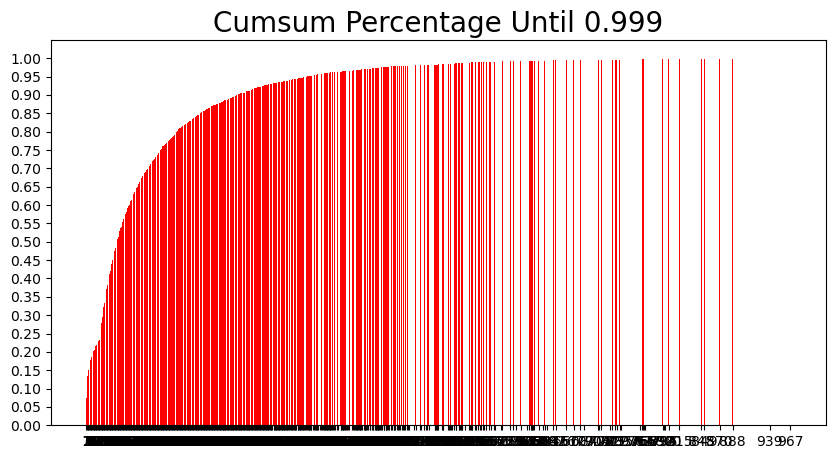

In [28]:
plt.figure(figsize = (10, 5))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0,1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Train, Test, Validation Set Split


In [29]:
# 하나의 데이터셋에서 train, test, val을 분리시켜야 함 
# Session별로 나뉘니까 비율적으로 shuffle해서 train 0.7, val 0.2, test 0.1로 진행하고자 함 
session = rating_mod['Session'].unique()
session

import random 
random.shuffle(session)
session

type(session)
session = session.tolist()
session

total_len = len(session)
a = int(total_len*0.7)
b = int(total_len*0.9)

train_session = session[:a]
val_session = session[a : b]
test_session = session[b:]




In [30]:
# train_session list에 있는 Session을 train set으로 지정 
tr = rating_mod[rating_mod['Session'].isin(train_session)]
test = rating_mod[rating_mod['Session'].isin(test_session)]
val = rating_mod[rating_mod['Session'].isin(val_session)]

tr.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)
val.reset_index(drop = True, inplace = True)

In [33]:
print(len(tr), len(val), len(test))

357085 105489 44139


In [34]:
# data split확인 
tr['Session'].nunique(), val['Session'].nunique(), test['Session'].nunique()

(4228, 1208, 604)

### Data Pipeline 

In [35]:
# datapipeline 구축 
# 추후 사용할 수 있도록 pickle을 이용하여 데이터 저장 

save_path = file_path / 'clean_data_movieSBR'
save_path.mkdir(parents = True, exist_ok = True)

tr.to_pickle(save_path/'train.pkl')
test.to_pickle(save_path/'test.pkl')
val.to_pickle(save_path/'val.pkl')


In [36]:
# Session간 구분할 수 있게 확인하는 function

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self,data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        # session별 index np.arange로 index 설정 
        self.session_idx = np.arange(self.df['Session'].nunique()) # indexing to sessionid


    # session별 누적 rating 개수 확인
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['Session'].nunique() +1, dtype = np.int32)
        # offsets의 맨 처음은 0으로 두고 다음것부터 cum한 값을 지정해라 
        offsets[1:] = self.df.groupby('Session').size().cumsum()
        return offsets


In [47]:
# 확인하고자 진행 
tr['Session'].nunique() + 1 # 독립적인 session 개수에 +1 
check = np.zeros(tr['Session'].nunique() + 1, dtype = np.int32) # 한 행으로 unique +1만큼 np 0

# print(tr.groupby('Session').size()) # session마다 몇개의 movieid를 갖고있는지 확인
print(tr.groupby('Session').size().cumsum()) # 누적 확인 

Session
1           13
2          142
3          193
8          332
9          438
         ...  
6035    356053
6036    356941
6038    356961
6039    357084
6040    357085
Length: 4228, dtype: int64


In [49]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(14)

,Session,Movieid,Rating,Time,Usertimemax,Timeminusmax,days
0,1,1545,4,2001-01-06 23:35:39,2001-01-06 23:39:11,0 days 00:03:32,0
1,1,527,5,2001-01-06 23:36:35,2001-01-06 23:39:11,0 days 00:02:36,0
2,1,595,5,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
3,1,2687,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
4,1,745,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
5,1,588,4,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
6,1,1,5,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
7,1,2355,5,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0
8,1,2294,4,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0
9,1,783,4,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0


In [50]:
# session별 누적 rating 수 확인 
tr_dataset.click_offsets[:20]

array([   0,   13,  142,  193,  332,  438,  520,  543,  651,  676,  711,
       1016, 1018, 1040, 1045, 1054, 1070, 1113, 1232, 1329], dtype=int32)

In [77]:
# tr_dataset 인덱스 개수
tr_dataset.session_idx
tr_dataset.session_idx.max() - tr_dataset.session_idx.min() #4227

4227

In [73]:
#parallel minibatch 생성 

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=1048):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Movie indices(인덱스) that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target Movie indices
            masks: Numpy array indicating the positions of the sessions to be terminated
            세션이 끝나는 위치 나타내는 np array
        """

        start, end, mask, last_session, finished = self.initialize() 
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished: # True면
            min_len = (end - start).min() - 1 # session이 끝난 인덱스 - 시작 인덱스 
            for i in range(min_len): # generator(iter가 아닌 제너레이터): 이터레이터를 생성해주는 함수 
                # Build inputs & targets
                inp = self.dataset.df['Movieid'].values[start + i] # 인덱스값의 values[확인하고자 하는]
                target = self.dataset.df['Movieid'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        # 배치사이즈 arange화. 현 setting batch_size가 1024이고, tr_dataset 사이즈가 4227이기 때문에 4가됨
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1  

        # self.session_idx = np.arange(self.df['Session'].nunique()) 였어
        # 첫번째 iter
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]] 
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1] 
        mask = np.array([])  
        finished = False      
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
    
        start += min_len   
        mask = np.arange(self.batch_size)[(end - start) == 1]  


        for i, idx in enumerate(mask, start=1):  
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  
        return start, end, mask, last_session, finished


In [89]:
# function 확인
first_iters = np.arange(tr_data_loader.batch_size)
print(tr_data_loader.batch_size) #4

#start
tr_data_loader.dataset.session_idx[first_iters] # 전체인덱스중에서 앞에서 4개
tr_data_loader.dataset.session_idx # 전체 index
# first_iters
tr_data_loader.initialize() # start는 session 별 rating 누적 개수 
# 즉 start는 input의 처음이 되는 index
# end는 그 다음 input이 되는 index? 

4


(array([  0,  13, 142, 193], dtype=int32),
 array([ 13, 142, 193, 332], dtype=int32),
 array([], dtype=float64),
 3,
 False)

In [81]:
tr_data_loader.initialize()

(array([  0,  13, 142, 193], dtype=int32),
 array([ 13, 142, 193, 332], dtype=int32),
 array([], dtype=float64),
 3,
 False)

In [57]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size = 4)
tr_dataset.df.head(10)

,Session,Movieid,Rating,Time,Usertimemax,Timeminusmax,days
0,1,1545,4,2001-01-06 23:35:39,2001-01-06 23:39:11,0 days 00:03:32,0
1,1,527,5,2001-01-06 23:36:35,2001-01-06 23:39:11,0 days 00:02:36,0
2,1,595,5,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
3,1,2687,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
4,1,745,3,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
5,1,588,4,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
6,1,1,5,2001-01-06 23:37:48,2001-01-06 23:39:11,0 days 00:01:23,0
7,1,2355,5,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0
8,1,2294,4,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0
9,1,783,4,2001-01-06 23:38:11,2001-01-06 23:39:11,0 days 00:01:00,0


In [90]:
iter_ex = iter(tr_data_loader)
iter_ex

<generator object SessionDataLoader.__iter__ at 0x7fc1c1692f50>

In [91]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [1545 1198  593 1210]
Label Item Idx are :       [ 527 1210 2858  111]
Previous Masked Input Idx are []


### Modeling 
- 해당 부분부터 이해가 잘 가지 않아서 진행하지 못함 